### 本文档解决的问题是：
### 不同分布地点的加工厂分别与什么变量的关系更大
### 首先通过相关性分析去掉共线变量

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box,Polygon
from shapely.geometry import box
import analysis_tool as tool

In [6]:
gdfs = tool.load_all_gdfs("origin_data")

✅  已加载 00_Boundaries: Whole area.shp (1 条记录, 0.08 MB)
✅  已加载 01_production_farming: farming.shp (1647 条记录, 2.90 MB)
✅  已加载 02_production_aquaculture: aquaculture.shp (211 条记录, 2.49 MB)
✅  已加载 03_production_livestock: livestock.shp (1538 条记录, 1.61 MB)
✅  已加载 04_transformation_industry: processing.shp (58 条记录, 0.00 MB)
✅  已加载 05_transformation_energy: energy.shp (147 条记录, 0.03 MB)
✅  已加载 06_logistics_transportation: transportation.shp (656 条记录, 0.28 MB)
✅  已加载 07_logistics_roads: roads_highways.shp (58252 条记录, 6.92 MB)
✅  已加载 08_supply_retail: shop_food_beverage_data.shp (432 条记录, 0.01 MB)
✅  已加载 09_supply_public_services: public_services.shp (911 条记录, 0.02 MB)
✅  已加载 10_built_environment: buildings.shp (189600 条记录, 54.22 MB)
✅  已加载 11_consumption_facilities: consumption_data.shp (2889 条记录, 0.08 MB)
✅  已加载 12_consumption_landuse_mix: landuse_mix.shp (7124 条记录, 2.28 MB)
✅  已加载 13_waste_treatment: impianti_smaltimento_rifiuti.shp (10 条记录, 0.00 MB)


     farming_area_norm  aquaculture_area_norm  pasture_area_norm  \
0             0.098866               0.000000           0.000037   
1             0.212885               0.000000           0.032415   
2             0.331625               0.000000           0.093858   
3             0.039190               0.000000           0.000000   
4             0.149670               0.000000           0.022438   
..                 ...                    ...                ...   
171           0.001035               0.000000           0.002241   
172           0.000000               0.000000           0.000000   
173           0.452223               0.000000           0.028468   
174           0.271784               0.000000           0.048305   
175           0.000000               0.018777           0.000479   

     energy_area_norm  transportation_area_norm  retail_count_norm  \
0            0.000000                  0.000000           0.000000   
1            0.000000                  0.00

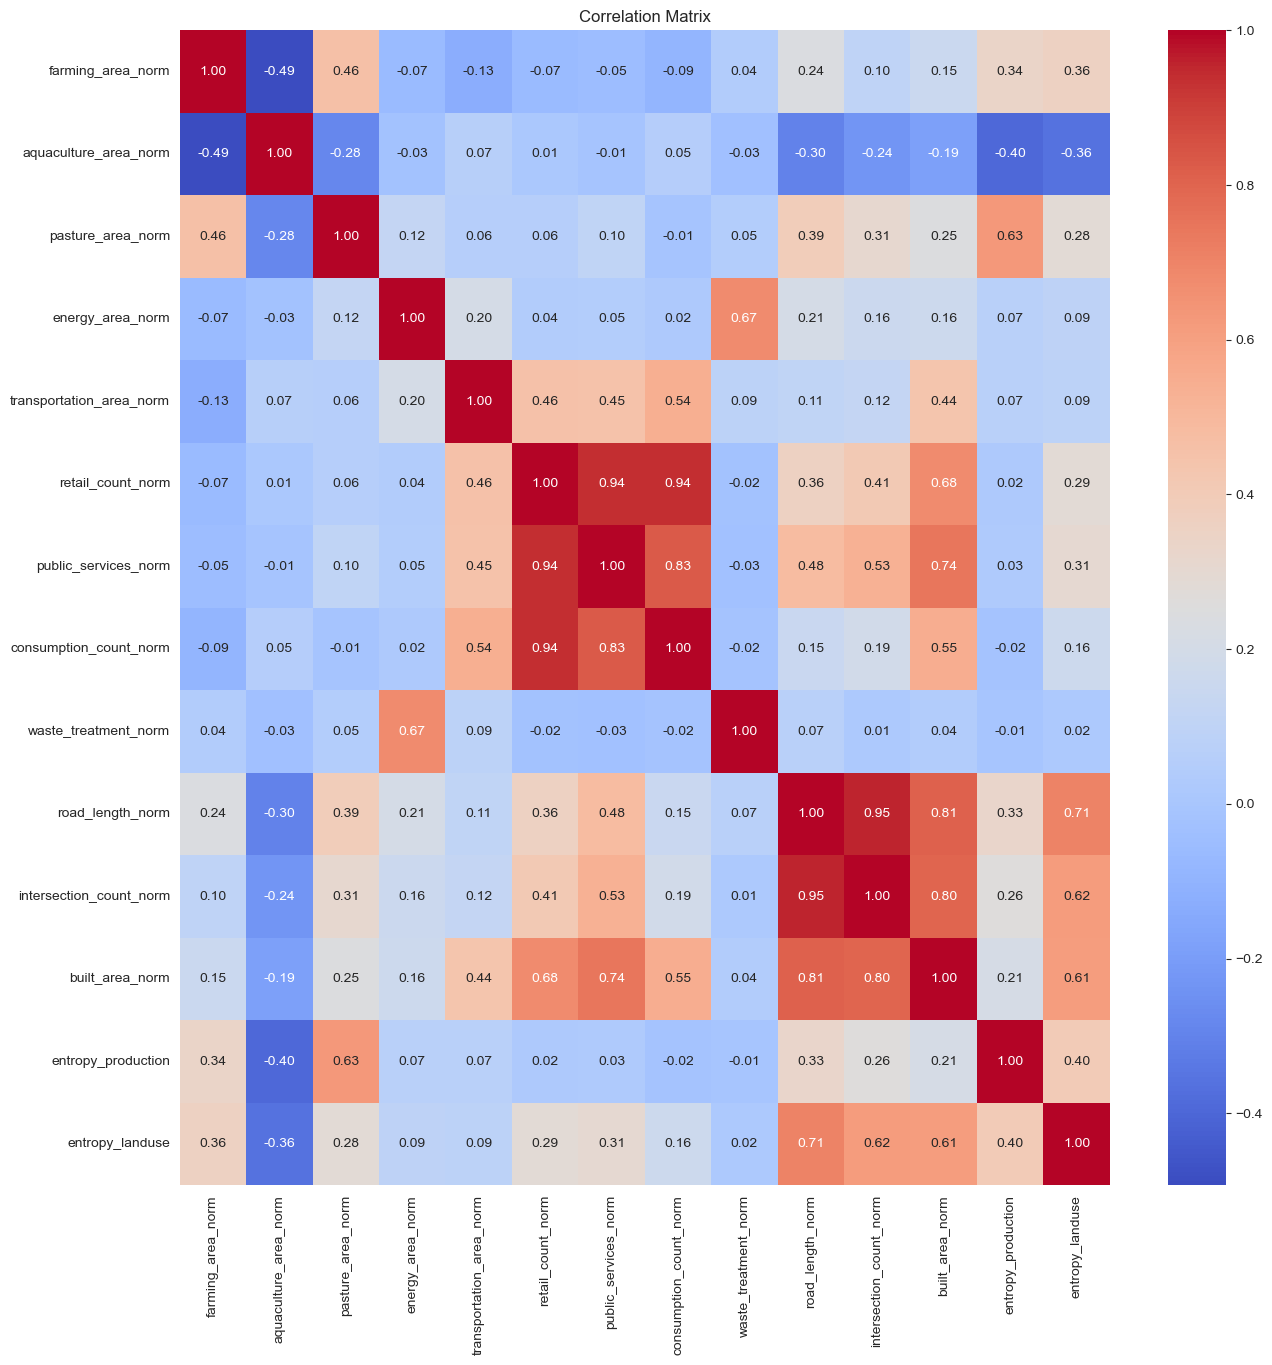

In [7]:
import seaborn as sns
import pandas as pd
patches = gpd.read_file("processing_data\grid\grid_normalized_3000.geojson")

# 只提取需要分析的字段
df_analysis = patches[['farming_area_norm','aquaculture_area_norm',
       'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
       'retail_count_norm', 'public_services_norm',
       'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
       'intersection_count_norm','built_area_norm',
       'entropy_production', 'entropy_landuse']]
print(df_analysis)
# 计算相关性矩阵
corr_matrix = df_analysis.corr()
corr_matrix.to_csv("correlation_matrix.csv")
# 热力图可视化
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### 通过计算VIF排除共线性变量

In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
import numpy as np

# 标准化变量（非必须但推荐）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_analysis.dropna())  # 去除 NaN 影响

# 重新构建为 DataFrame
X_df = pd.DataFrame(X_scaled, columns=df_analysis.columns)

# 计算 VIF
vif_df = pd.DataFrame()
vif_df["Variable"] = X_df.columns
vif_df["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

# vif_df.to_csv("vif_result.csv", index=False)
print(vif_df)

# 根据结论：
# consumption_count 与 retail_count，public_services， built_area
#

                    Variable        VIF
0          farming_area_norm   2.061040
1      aquaculture_area_norm   1.526178
2          pasture_area_norm   2.236819
3           energy_area_norm   2.142779
4   transportation_area_norm   2.026047
5          retail_count_norm  38.281933
6       public_services_norm  14.428957
7     consumption_count_norm  19.619452
8       waste_treatment_norm   1.927809
9           road_length_norm  23.351540
10   intersection_count_norm  16.720083
11           built_area_norm   8.561646
12        entropy_production   2.027240
13           entropy_landuse   2.781111


#  GWR分析
## 在进行分析之前，首先有OLS回归模型的分析

In [5]:
# patches = gpd.read_file("processing_data/patch/patches_normalized_1000.geojson")
patches = gpd.read_file("processing_data\grid\grid_normalized_3000.geojson")
print(patches.columns)

Index(['farming_area_norm', 'aquaculture_area_norm', 'pasture_area_norm',
       'energy_area_norm', 'transportation_area_norm', 'factory_count_norm',
       'retail_count_norm', 'public_services_norm', 'consumption_count_norm',
       'waste_treatment_norm', 'road_length_norm', 'intersection_count_norm',
       'built_area_norm', 'entropy_production', 'entropy_landuse', 'geometry'],
      dtype='object')


## 筛选有效网格进行分析

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULL

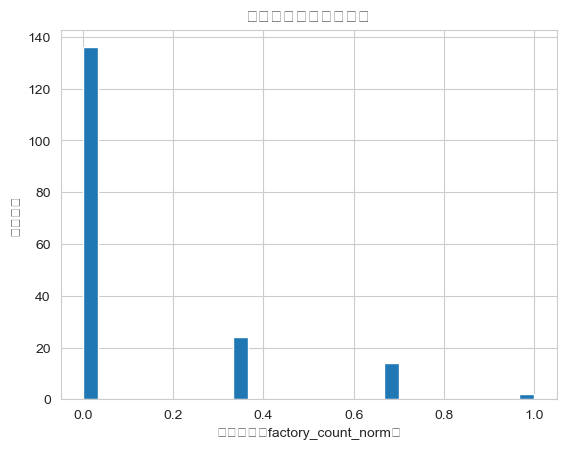

D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24402 (\N{CJK UNIFIED IDEOGRAPH-5F52}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 19968 (\N{CJK UNIFIED IDEOGRAPH-4E00}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
D:\STUDY\anaconda3\envs\urban_morphology\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 65288 (\N{FULL

factory_count_norm
0.000000    0.772727
0.333333    0.136364
0.666667    0.079545
1.000000    0.011364
Name: proportion, dtype: float64


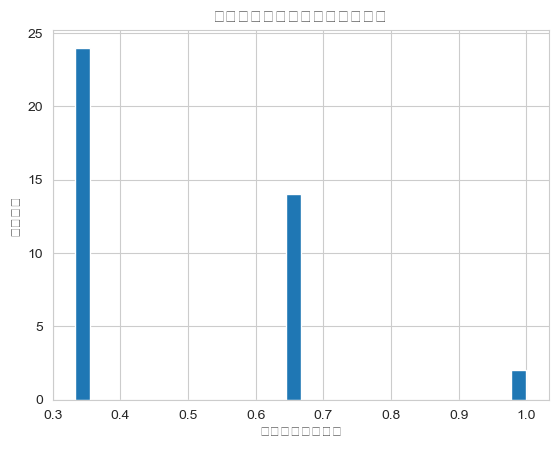

In [10]:
# 查看多少网格加工厂数量为零

import geopandas as gpd

patches = gpd.read_file("processing_data/grid/grid_normalized_3000.geojson")

import matplotlib.pyplot as plt

patches['factory_count_norm'].hist(bins=30)
plt.title('加工厂归一化数量分布')
plt.xlabel('归一化值（factory_count_norm）')
plt.ylabel('网格数量')
plt.grid(True)
plt.show()

# 查看不同值出现的频率（前10行）
value_counts = patches['factory_count_norm'].value_counts(normalize=True).sort_index()
print(value_counts.head(10))

non_zero = patches[patches['factory_count_norm'] > 0]
non_zero['factory_count_norm'].hist(bins=30)
plt.title('有加工厂区域的归一化数量分布')
plt.xlabel('归一化值（非零）')
plt.ylabel('网格数量')
plt.grid(True)
plt.show()


In [9]:
# 保留有工厂的/邻近的网格

import geopandas as gpd

patches = gpd.read_file("processing_data/grid/grid_normalized.geojson")

# 保留有工厂的网格（归一化值 > 0）
patches_with_factory = patches[patches['factory_count_norm'] > 0].copy()

# 保存以备检查
patches_with_factory.to_file("processing_data/grid/patches_with_factory_only.geojson")

print(f"✅ 有效网格数量（包含工厂）: {len(patches_with_factory)}")

# 创建 1000 米缓冲区
buffer = patches_with_factory.buffer(1000)
# 合并为一个大区块
buffer_union = buffer.unary_union

# 找出所有在缓冲区内的网格
patches_in_buffer = patches[patches.geometry.centroid.within(buffer_union)].copy()
# 保存结果
patches_in_buffer.to_file("processing_data/grid/patches_with_factory_and_neighbors.geojson")

print(f"✅ 缓冲区内总网格数量: {len(patches_in_buffer)}")



✅ 有效网格数量（包含工厂）: 55


C:\Users\Elena\AppData\Local\Temp\ipykernel_15068\2720397745.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_union = buffer.unary_union


✅ 缓冲区内总网格数量: 375


## 显著性检验（Moran’s I）是否有必要GWR

In [19]:
import libpysal
# import scipy

print("libpysal version:", libpysal.__version__)
# print("scipy version:", scipy.__version__)

libpysal version: 4.8.1


In [20]:
# 显著性检验（Moran’s I）：
#     GWR 前提是变量与目标之间在空间上存在“局部异质性”;
#     若 Moran’s I 显著为正 → 支持 GWR 合理性（如同 Chen 论文中残差的空间自相关检验）

from esda.moran import Moran
from libpysal.weights import KNN
patches= gpd.read_file(r"processing_data\grid\grid_normalized_3000.geojson")

w = KNN.from_dataframe(patches, k=8)
moran = Moran(patches['factory_count_norm'], w)
print(moran.I, moran.p_sim)

# 结果说明：Moran’s I正值，说明空间上存在轻度的正相关性（即“聚集”）
# p_sim=0.001，非常显著（p < 0.01），说明这种空间聚集并非偶然

# ✅ 结论
# 你当前的目标变量 factory_count_norm 在空间上具有显著的正向空间自相关性。
# ✅ 工厂数量在空间上“有聚集趋势”，而不是完全随机；
# ✅ 使用 地理加权回归（GWR）是合理且有必要的；
# ⚠️ 虽然整体聚集性不强（I ≈ 0.05），但显著性高，说明某些局部确实存在工厂聚集“热点区域”；
# ✅ GWR 正是为了揭示这种“不同地点影响因素不一样”的现象设计的。

0.12463987323537884 0.001


## OLS & GWR 建模

In [6]:
import geopandas as gpd
import pandas as pd
import numpy as np
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# === 1. 加载数据 ===
# patches = gpd.read_file("processing_data\grid\patches_with_factory_and_neighbors.geojson")
# patches= gpd.read_file("processing_data\grid\grid_normalized_3000.geojson")
# print(len(patches))

print(patches.columns)
# Index(['grid_id', 'farming_area_norm', 'aquaculture_area_norm',
#        'pasture_area_norm', 'energy_area_norm', 'transportation_area_norm',
#        'factory_count_norm', 'retail_count_norm', 'public_services_norm',
#        'consumption_count_norm', 'waste_treatment_norm', 'road_length_norm',
#        'intersection_count_norm', 'built_area_norm', 'entropy_production',
#        'entropy_landuse', 'geometry'],
#       dtype='object')
# === 2. 选择变量 & 去除共线变量 ===
selected_vars = ['farming_area_norm','aquaculture_area_norm','pasture_area_norm','energy_area_norm',
                 'transportation_area_norm','retail_count_norm','public_services_norm','waste_treatment_norm',
                 'road_length_norm','built_area_norm','entropy_production','entropy_landuse']
## 去掉了 'consumption_count_norm','intersection_count_norm'

# X_raw = patches[selected_vars].dropna()
# y = patches['factory_count_norm'].values.reshape(-1, 1) # 替换为你真实的目标变量列名
# # y = np.ones((X_raw.shape[0], 1))

X_raw = patches[selected_vars]
y_raw = patches['factory_count_norm']
print(len(X_raw ))
print(len(y_raw))
mask = X_raw.notnull().all(axis=1) & y_raw.notnull()
X_raw = X_raw[mask]
y_raw= y_raw[mask]
# print(len(y))

# === 3. 标准化变量（推荐） ===
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)
y = y_raw.values.reshape(-1, 1)

# === 4. OLS 回归 ===
X_ols = sm.add_constant(X)
ols_model = sm.OLS(y, X_ols).fit()
print("=== OLS 模型结果 ===")
print(ols_model.summary())

# === 5. GWR 准备坐标 ===
# coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in patches.loc[X_raw.index].geometry])
# coords = np.array([[geom.x, geom.y] for geom in  patches.geometry.centroid])
coords = np.array([(geom.centroid.x, geom.centroid.y) for geom in patches.geometry])


# === 6. 选择最优带宽 ===
selector = Sel_BW(coords, y, X)
bw = selector.search(bw_min=2, bw_max=100)
print(f"✅ GWR 最优带宽: {bw}")


# === 7. 拟合 GWR 模型 ===
gwr_model = GWR(coords, y, X, bw)
gwr_results = gwr_model.fit()

# === 8. 输出比较指标 ===
print("\n=== 模型指标对比 ===")
print(f"GWR AICc : {gwr_results.aicc:.4f}")   # 改为小写 aicc
print(f"OLS AIC  : {ols_model.aic:.4f}")
print(f"GWR R2   : {gwr_results.R2:.4f}")
print(f"OLS R2   : {ols_model.rsquared:.4f}")


# === 9. 输出每个点的回归系数表 ===
beta_df = pd.DataFrame(gwr_results.params, columns=["Intercept"] + selected_vars)
beta_df["R2_local"] = gwr_results.localR2
beta_df.to_csv("gwr_coefficients.csv", index=False)

# === 10. 若需要合并到 GeoDataFrame 可视化 ===
patches_gwr = patches.loc[X_raw.index].copy()
for i, var in enumerate(["Intercept"] + selected_vars):
    patches_gwr[f'beta_{var}'] = gwr_results.params[:, i]
patches_gwr["R2_local"] = gwr_results.localR2
patches_gwr.to_file("patches_with_gwr.geojson", driver="GeoJSON")




Index(['farming_area_norm', 'aquaculture_area_norm', 'pasture_area_norm',
       'energy_area_norm', 'transportation_area_norm', 'factory_count_norm',
       'retail_count_norm', 'public_services_norm', 'consumption_count_norm',
       'waste_treatment_norm', 'road_length_norm', 'intersection_count_norm',
       'built_area_norm', 'entropy_production', 'entropy_landuse', 'geometry'],
      dtype='object')
176
176
=== OLS 模型结果 ===
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     7.168
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           1.99e-10
Time:                        20:17:49   Log-Likelihood:                 51.533
No. Observations:                 176   AIC:                            -77.07
Df Residuals:

### 输出 OLS 标准化回归系数（SC）+ p值 + R²

In [24]:
# 输出 OLS 标准化回归系数（SC）+ p值 + R² 表格
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# 准备数据
X = X_raw.copy()
y = y_raw.copy()

# 标准化X和y
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1)).flatten()

# OLS模型拟合（标准化数据）
X_ols = sm.add_constant(X_scaled)
ols_model = sm.OLS(y_scaled, X_ols).fit()

# 输出标准化回归系数（SC）+ p值表格
sc_results = pd.DataFrame({
    'Variable': ['Intercept'] + list(X.columns),
    'Standardized Coef (SC)': ols_model.params,
    'p-value': ols_model.pvalues
})

# 添加Adjusted R² 到表格
adjusted_r2 = ols_model.rsquared_adj
sc_results['Adjusted R²'] = [adjusted_r2] + [''] * (len(sc_results)-1)

print("✅ OLS标准化回归系数（SC）+ p值 + Adjusted R² 结果表格:")
print(sc_results)

# 保存为CSV
sc_results.to_csv("ols_SC_pvalue_r2.csv", index=False)


✅ OLS标准化回归系数（SC）+ p值 + Adjusted R² 结果表格:
                    Variable  Standardized Coef (SC)   p-value Adjusted R²
0                  Intercept           -1.249001e-16  1.000000    0.297243
1          farming_area_norm            2.593973e-01  0.002992            
2      aquaculture_area_norm            8.782559e-02  0.261957            
3          pasture_area_norm           -7.117824e-02  0.452884            
4           energy_area_norm            3.513668e-02  0.703788            
5   transportation_area_norm           -9.788562e-02  0.253769            
6          retail_count_norm            1.206701e-01  0.566469            
7       public_services_norm           -3.597899e-01  0.111283            
8       waste_treatment_norm           -1.022416e-01  0.246044            
9           road_length_norm           -1.082177e-01  0.507719            
10           built_area_norm            6.761696e-01  0.000208            
11        entropy_production            3.466208e-02  0.701

### 自动变量组合筛选

In [25]:
# 自动进行变量组合筛选，并输出表现指标表格
import itertools
import warnings
warnings.filterwarnings('ignore')  # 抑制可能的警告

# 存储结果的DataFrame
comb_results = []

variables = X.columns.tolist()

# 遍历2到len(variables)个变量的所有组合
for r in range(2, len(variables)+1):
    for var_comb in itertools.combinations(variables, r):

        X_subset = X[list(var_comb)]

        # 标准化
        X_scaled_subset = scaler_X.fit_transform(X_subset)
        X_ols_subset = sm.add_constant(X_scaled_subset)

        # 拟合模型
        model_subset = sm.OLS(y_scaled, X_ols_subset).fit()

        # 存储组合的表现指标
        comb_results.append({
            'Variables': ', '.join(var_comb),
            'Adjusted R²': model_subset.rsquared_adj,
            'AIC': model_subset.aic
        })

# 创建DataFrame并排序
comb_results_df = pd.DataFrame(comb_results)
comb_results_df.sort_values(by='Adjusted R²', ascending=False, inplace=True)

# 打印并保存
print("✅ 自动变量组合筛选结果（前10个最佳组合）:")
print(comb_results_df.head(10))

comb_results_df.to_csv("variable_combination_results.csv", index=False)


✅ 自动变量组合筛选结果（前10个最佳组合）:
                                              Variables  Adjusted R²  \
3487  farming_area_norm, aquaculture_area_norm, tran...     0.309927   
2947  farming_area_norm, transportation_area_norm, p...     0.309423   
2612  farming_area_norm, aquaculture_area_norm, past...     0.309282   
1772  farming_area_norm, aquaculture_area_norm, publ...     0.309114   
2732  farming_area_norm, aquaculture_area_norm, reta...     0.308361   
1898  farming_area_norm, pasture_area_norm, public_s...     0.308007   
3398  farming_area_norm, aquaculture_area_norm, past...     0.307951   
3475  farming_area_norm, aquaculture_area_norm, tran...     0.307923   
2720  farming_area_norm, aquaculture_area_norm, tran...     0.307911   
2717  farming_area_norm, aquaculture_area_norm, tran...     0.307691   

             AIC  
3487  443.942356  
2947  443.121625  
2612  443.157654  
1772  442.244772  
2732  443.392170  
1898  442.526637  
3398  444.445638  
3475  444.452623  
2720  443.50

### 局部回归系数绘图

176


C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:55: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")


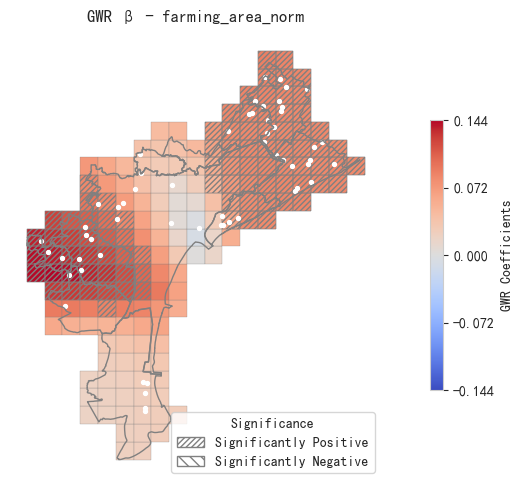

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:54: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_pos.plot(ax=ax, facecolor='none', hatch='//////', edgecolor='grey', linewidth=0.3, label="Significantly Positive")
C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:55: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")


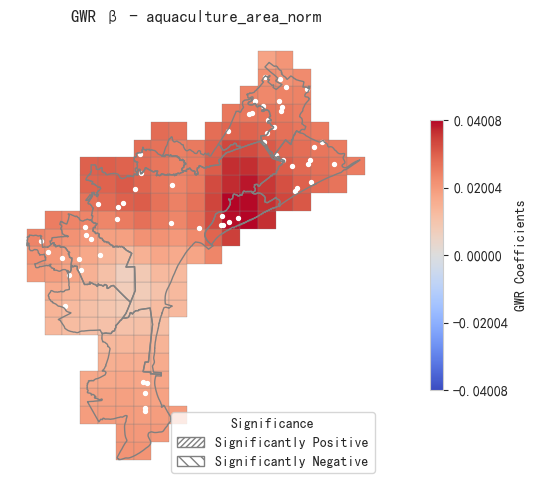

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:54: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_pos.plot(ax=ax, facecolor='none', hatch='//////', edgecolor='grey', linewidth=0.3, label="Significantly Positive")
C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:55: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")


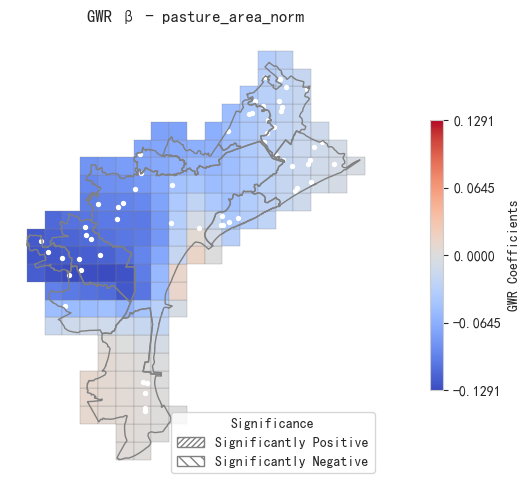

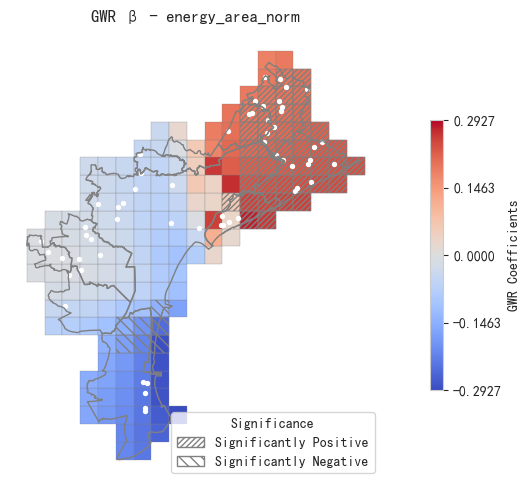

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:54: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_pos.plot(ax=ax, facecolor='none', hatch='//////', edgecolor='grey', linewidth=0.3, label="Significantly Positive")


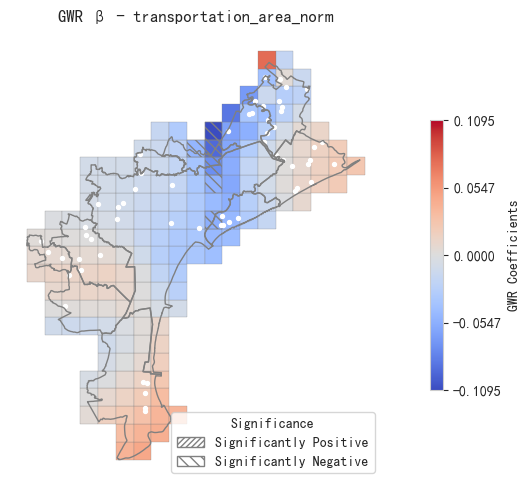

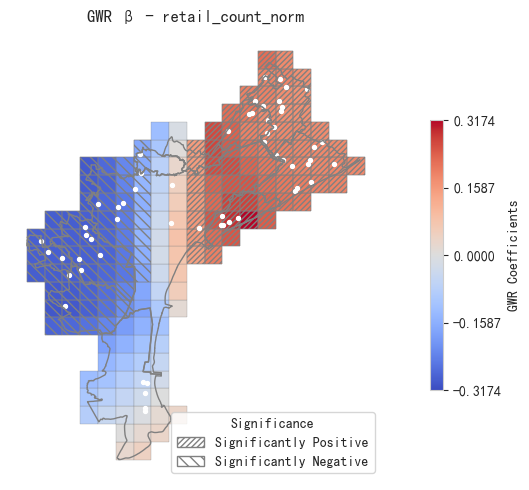

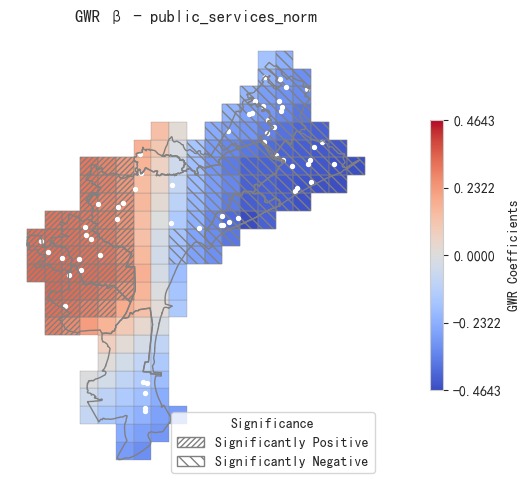

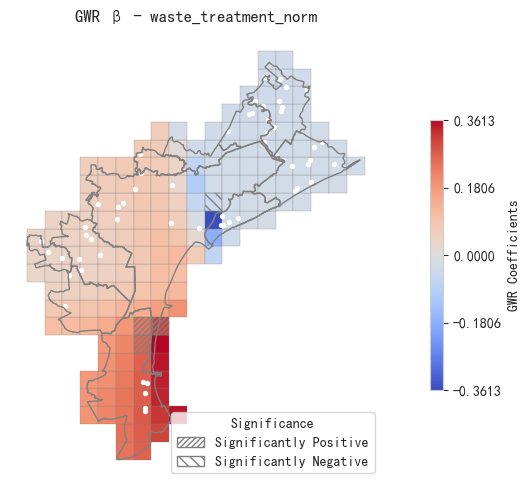

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:54: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_pos.plot(ax=ax, facecolor='none', hatch='//////', edgecolor='grey', linewidth=0.3, label="Significantly Positive")


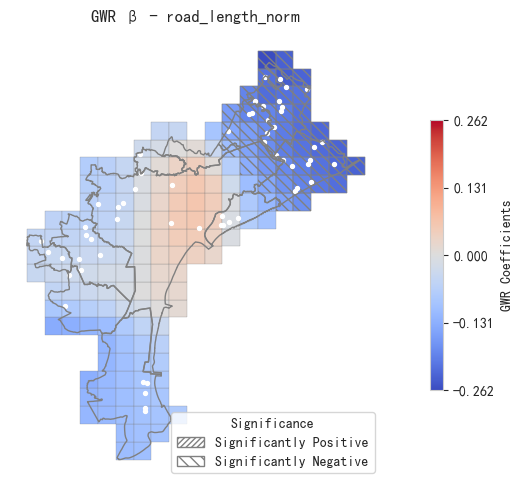

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:55: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")


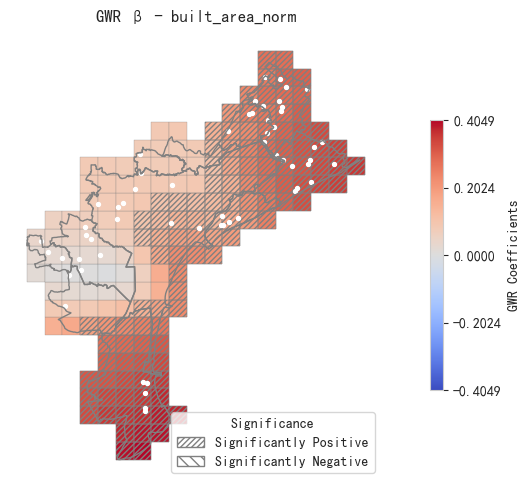

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:55: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")


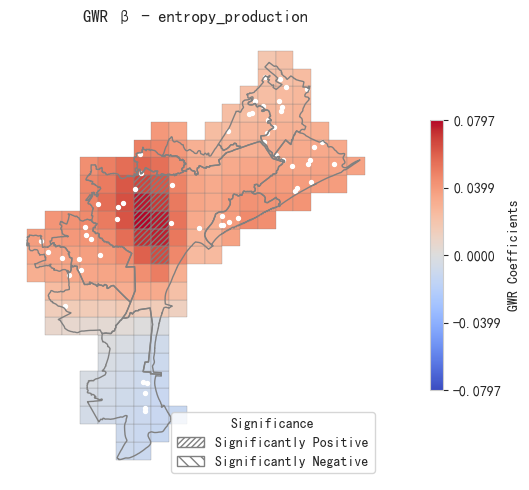

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\2971248529.py:55: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")


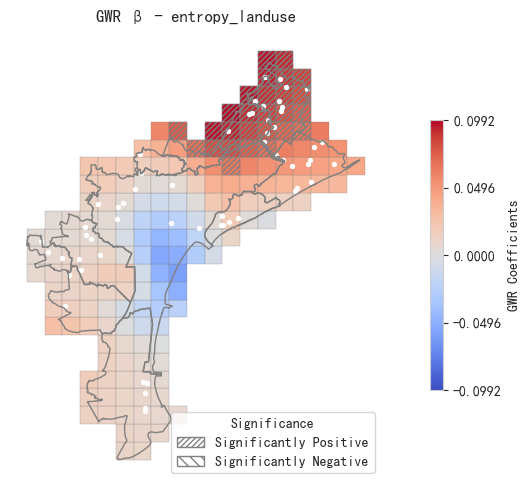

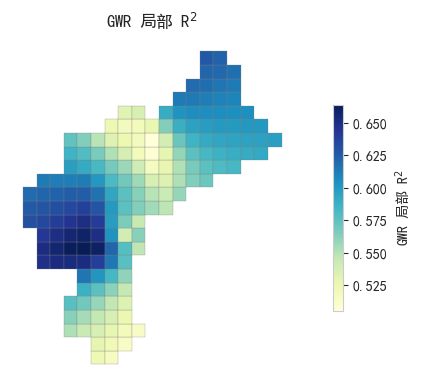

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 中文与负号支持
plt.rcParams['font.sans-serif'] = ['SimHei']      # 中文字体（黑体）
plt.rcParams['axes.unicode_minus'] = False        # 负号正常显示

# === 1. 准备变量名列表（含 Intercept）===
coeff_names = ["Intercept"] + list(X_raw.columns)

# === 2. 提取参与 GWR 的网格数据（排除 NaN）===
# patches_gwr = patches.loc[X_raw.index].copy()
print(len(patches_gwr))
# === 3. 写入 GWR 模型输出（系数）===
for i, var in enumerate(coeff_names):
    patches_gwr[f'beta_{var}'] = gwr_results.params[:, i]

# === 4. 写入局部 R² ===
patches_gwr["R2_local"] = gwr_results.localR2

# === 5. 定义绘图函数（每个变量独立色带、对称于0）===
def plot_gwr_result(gdf, column, title,significance_col,processing,boundary):
    fig, ax = plt.subplots(1, 1, figsize=(10,5))

    # 保持色带对称（中心为0）
    col_data = gdf[column]
    bound = max(abs(col_data.min()), abs(col_data.max()))
    ticks = np.linspace(-bound, bound, 5)

    gdf.plot(
        column=column,
        cmap="coolwarm",
        ax=ax,
        legend=True,
        vmin=-bound,
        vmax=bound,
        legend_kwds={
            'label': "GWR Coefficients",
            'shrink': 0.6,
            'ticks': ticks,
            'location':'right'
        },
        edgecolor='grey',
        linewidth=0.2
    )

        # === 显著性叠加图层（用 hatch）===
    if significance_col:
        sig_pos = gdf[gdf[significance_col] == 1]
        sig_neg = gdf[gdf[significance_col] == -1]

        sig_pos.plot(ax=ax, facecolor='none', hatch='//////', edgecolor='grey', linewidth=0.3, label="Significantly Positive")
        sig_neg.plot(ax=ax, facecolor='none', hatch='\\\\\\', edgecolor='grey', linewidth=0.3, label="Significantly Negative")

        # 添加图例（仅一次）
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='none', edgecolor='grey', hatch='//////', label='Significantly Positive'),
            Patch(facecolor='none', edgecolor='grey', hatch='\\\\\\', label='Significantly Negative'),
        ]
        ax.legend(handles=legend_elements, title="Significance", loc='lower right')


    processing.plot(ax=ax,color="white",markersize=8)
    boundary.plot(ax=ax,facecolor="none",edgecolor="grey",linewidth=1)
    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

processing= gpd.read_file("origin_data/04_transformation_industry").to_crs(epsg=32632)
boundary= gpd.read_file("origin_data/00_Boundaries/Municipalties").to_crs(epsg=32632)
# === 6. 批量绘制所有变量的局部系数热力图 ===
for var in X_raw.columns:
    plot_gwr_result(patches_gwr, f'beta_{var}', f"GWR β - {var}",f"sig_{var}",processing=processing,boundary= boundary)

# === 7. 单独绘制局部 R² 图（不做对称处理）===
def plot_r2(gdf, column="R2_local"):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    gdf.plot(
        column=column,
        cmap="YlGnBu",
        legend=True,
        ax=ax,
        legend_kwds={'label': "GWR 局部 R$^2$", 'shrink': 0.6},
        edgecolor='grey',
        linewidth=0.2
    )
    ax.set_title("GWR 局部 R$^2$")
    ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_r2(patches_gwr)


#### 局部回归系数绘图--保存图片

In [27]:
# 可编辑输出路径的 GWR 图像导出脚本
import os
import matplotlib.pyplot as plt
import numpy as np

# ✅ 👉 你只需修改这里：
output_path = r"G:\CODE\UrbanFood\processing_data\img"  # ← 修改为你希望的输出文件夹路径（如 "D:/GWR/图像/"）
image_format = "png"             # 可选："png"、"pdf"、"svg"
dpi = 300                        # 图像清晰度

# ✅ 执行导出函数
def export_gwr_maps(gdf, X_raw, output_dir, image_format="png", dpi=300):
    """
    批量导出 GWR 热力图（变量局部系数和局部 R²）到指定文件夹
    """
    os.makedirs(output_dir, exist_ok=True)
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False

    for var in X_raw.columns:
        column = f"beta_{var}"
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))

        bound = max(abs(gdf[column].min()), abs(gdf[column].max()))
        ticks = np.linspace(-bound, bound, 5)

        gdf.plot(
            column=column,
            cmap="coolwarm",
            ax=ax,
            legend=True,
            vmin=-bound,
            vmax=bound,
            legend_kwds={
                'label': "GWR 回归系数",
                'shrink': 0.6,
                'ticks': ticks
            },
            edgecolor='grey',
            linewidth=0.2
        )

        ax.set_title(f"GWR β - {var}")
        ax.axis('off')
        plt.tight_layout()

        filename = f"gwr_beta_{var}.{image_format}"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, dpi=dpi)
        plt.close()

    # 保存局部 R² 图
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    gdf.plot(
        column="R2_local",
        cmap="YlGnBu",
        ax=ax,
        legend=True,
        legend_kwds={'label': "GWR 局部 R$^2$", 'shrink': 0.6},
        edgecolor='grey',
        linewidth=0.2
    )
    ax.set_title("GWR 局部 R$^2$")
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"gwr_R2_local.{image_format}"), dpi=dpi)
    plt.close()

    print(f"✅ 已成功导出 {len(X_raw.columns)+1} 张图像到：{output_dir}")

# ✅ 调用函数（路径来自你填写的 output_path）
export_gwr_maps(patches_gwr, X_raw, output_dir=output_path, image_format=image_format, dpi=dpi)


FileNotFoundError: [WinError 3] 系统找不到指定的路径。: 'G:\\'

### 新增功能：识别每个变量的显著性区域并绘图

     farming_area_norm  aquaculture_area_norm  pasture_area_norm  \
0             0.098866               0.000000           0.000037   
1             0.212885               0.000000           0.032415   
2             0.331625               0.000000           0.093858   
3             0.039190               0.000000           0.000000   
4             0.149670               0.000000           0.022438   
..                 ...                    ...                ...   
171           0.001035               0.000000           0.002241   
172           0.000000               0.000000           0.000000   
173           0.452223               0.000000           0.028468   
174           0.271784               0.000000           0.048305   
175           0.000000               0.018777           0.000479   

     energy_area_norm  transportation_area_norm  factory_count_norm  \
0            0.000000                  0.000000            0.000000   
1            0.000000                  0.

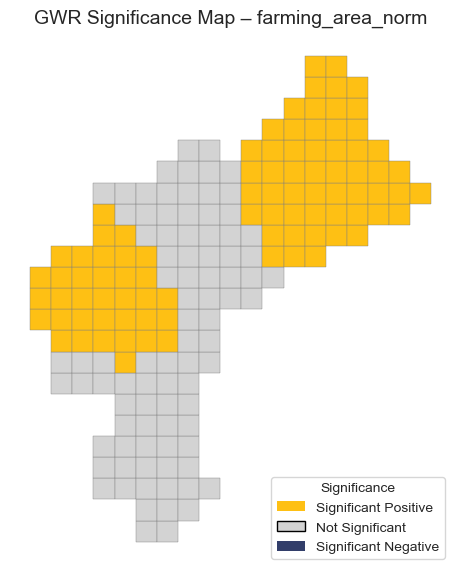

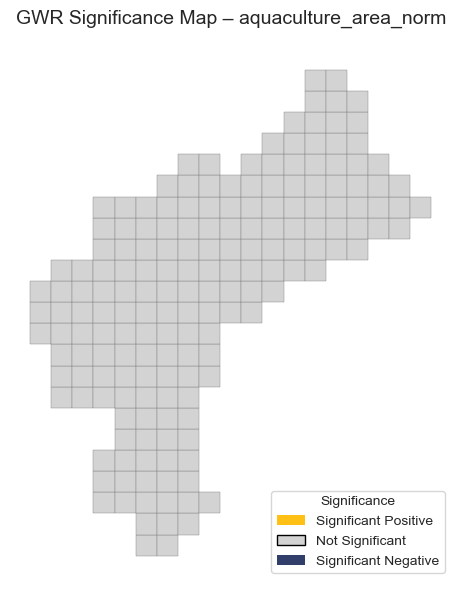

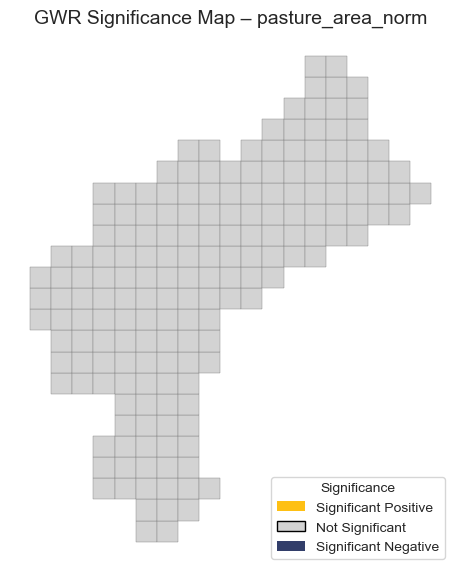

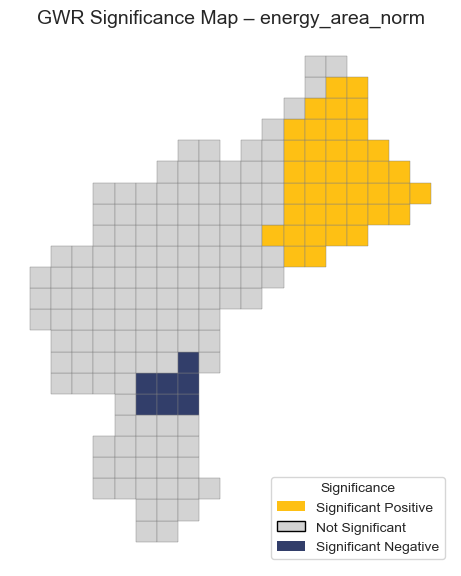

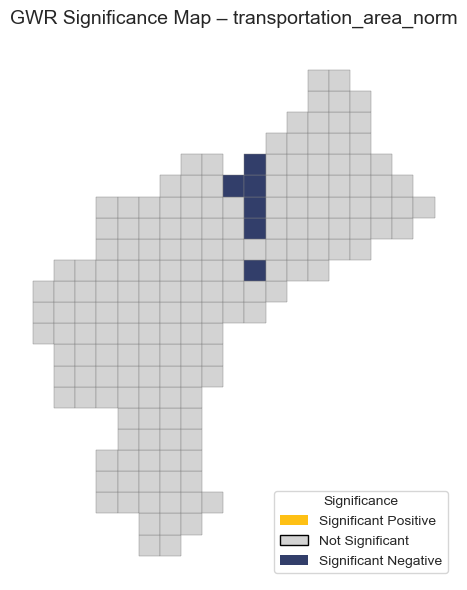

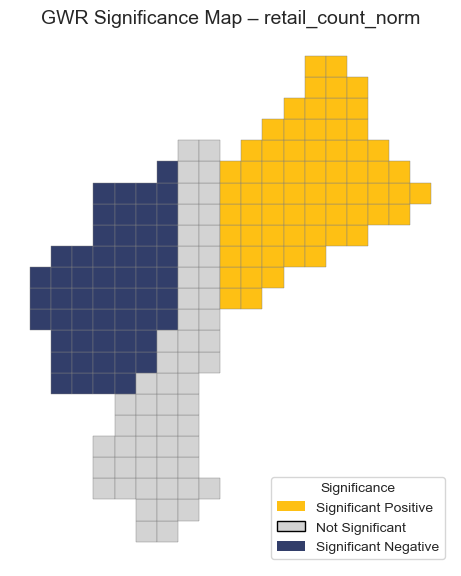

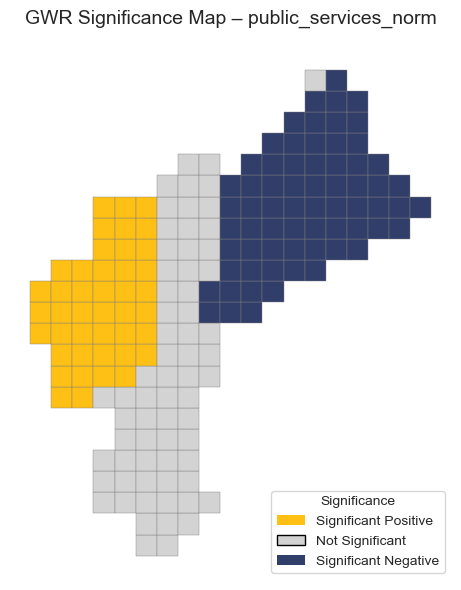

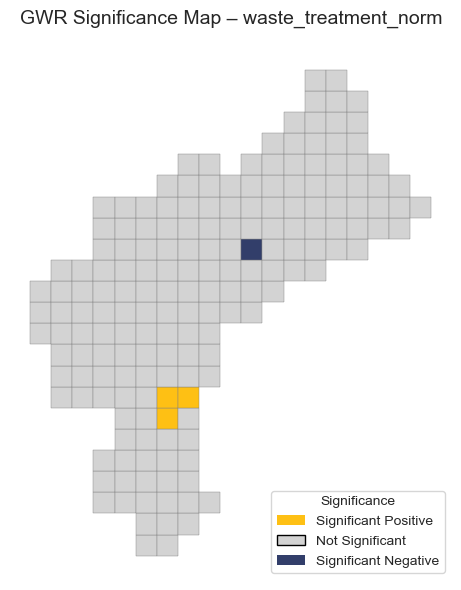

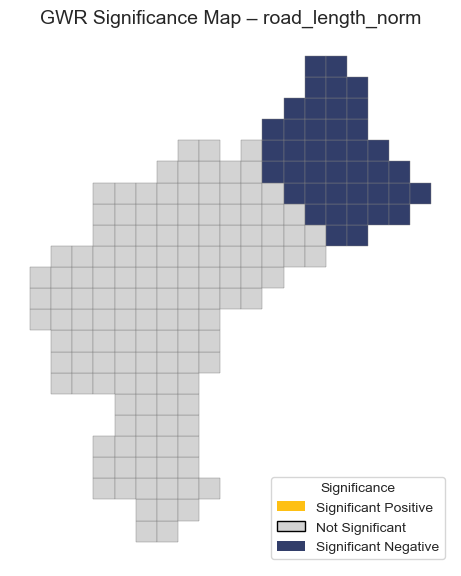

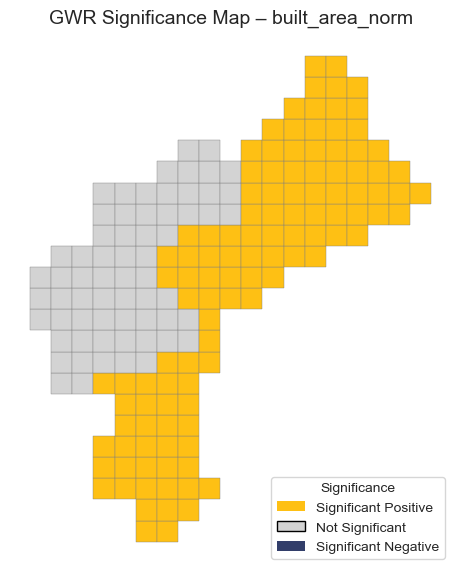

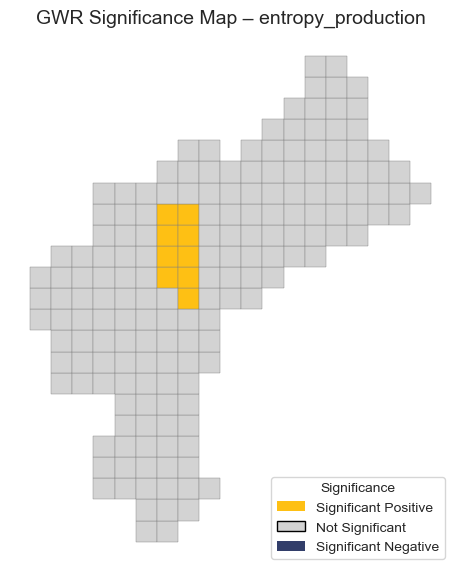

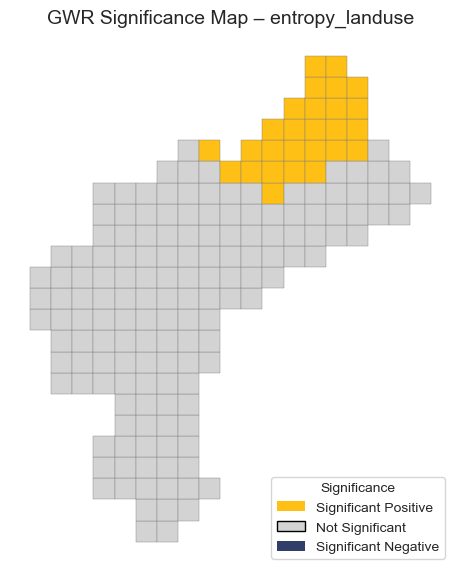

In [16]:
#新增功能：识别每个变量的显著性区域并绘图；  判断每个网格中，变量 β 系数是否在统计上显著；
# 使用 95% 置信区间（±1.96 × 标准误）进行判断；
# 输出显著性类别：1 = 显著正向影响；-1 = 显著负向影响；0 = 不显著
# 自动绘图展示每个变量的空间显著性区域。
# === 8. 显著性区域识别与可视化 ===
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

patches_gwr= gpd.read_file("patches_with_gwr.geojson")
print(patches)
print(gwr_results)
def plot_significance_zones(gdf, gwr_results, variable_names, z=1.96):
    """
    识别每个变量在空间上的显著区域，并绘图（±z·SE）
    """
    beta = gwr_results.params
    se = gwr_results.bse

    # 自定义颜色和标签
    cmap = ListedColormap(['#323E6A', 'lightgrey', '#FEC014'])  # -1, 0, 1
    legend_elements = [
        Patch(facecolor='#FEC014', edgecolor="none", label='Significant Positive'),
        Patch(facecolor='lightgrey', edgecolor='black', label='Not Significant'),
        Patch(facecolor='#323E6A', edgecolor='none', label='Significant Negative')
    ]

    for i, var in enumerate(variable_names):
        idx = i + 1  # 第0列是Intercept
        coef = beta[:, idx]
        stderr = se[:, idx]

        # 显著性判定
        lower = coef - z * stderr
        upper = coef + z * stderr
        sig = np.where(lower > 0, 1, np.where(upper < 0, -1, 0))

        sig_col = f"sig_{var}"
        gdf[sig_col] = sig

        # 绘图
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        gdf.plot(
            column=sig_col,
            cmap=cmap,
            ax=ax,
            edgecolor='grey',
            linewidth=0.3,
            vmin=-1, vmax=1,
        )

        ax.set_title(f"GWR Significance Map – {var}", fontsize=14)
        ax.axis('off')
        ax.legend(handles=legend_elements, loc='lower right', title="Significance")

        plt.tight_layout()
        plt.show()

# === 调用：对所有变量绘制显著性图 ===
plot_significance_zones(patches_gwr, gwr_results, list(X_raw.columns))

# 🔴 红色：该变量在该网格 显著正向影响工厂数量；
# 🔵 蓝色：显著负向影响；
# ⚪ 灰色：影响不显著。

### 双层视觉编码 bivariate visual encoding （空间统计方法的一种）
#### 回归系数大小（GWR β）：通过连续色谱（如红蓝渐变）表示；
#### 显著性区域：通过图案填充（如斜线 / 点状 / 网格）覆盖表示。

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\1042447771.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf[sig_col] == sig_val].plot(


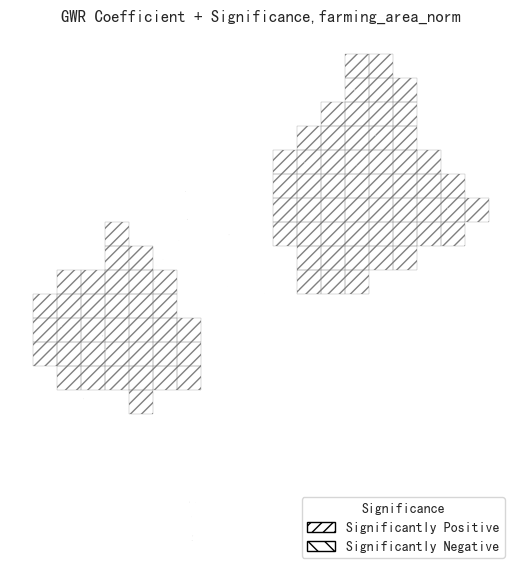

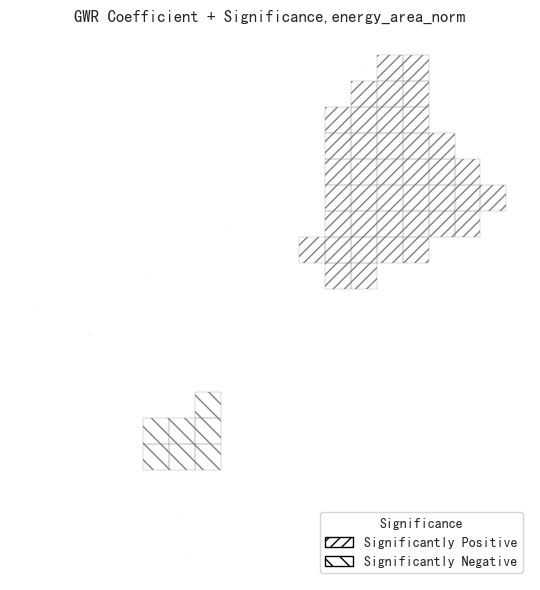

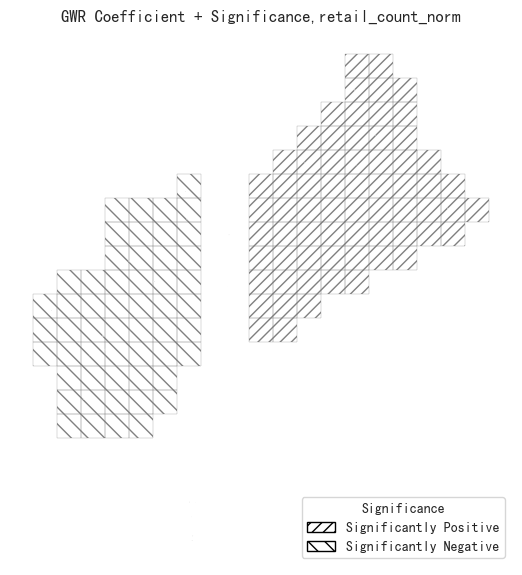

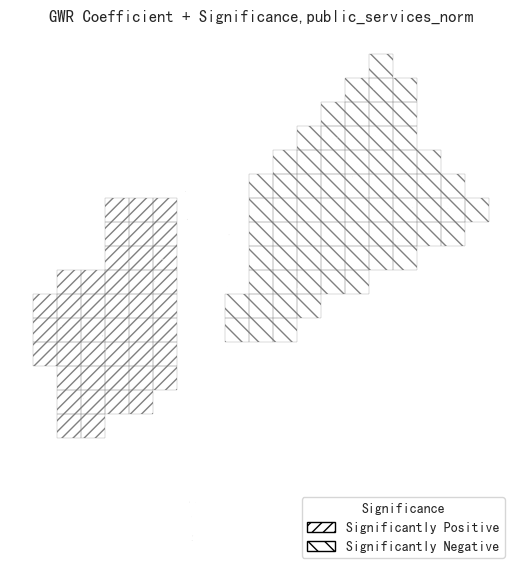

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\1042447771.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf[sig_col] == sig_val].plot(


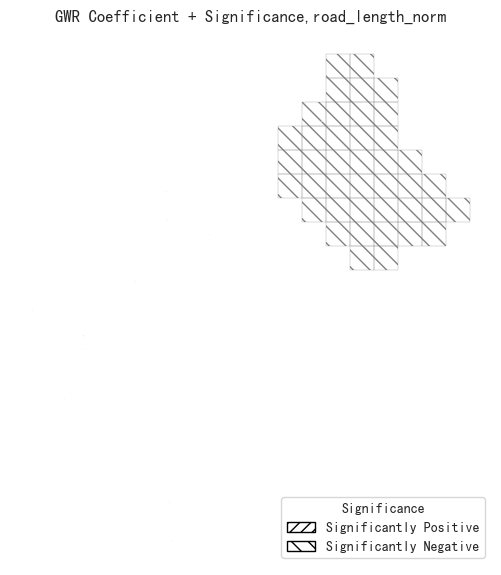

C:\Users\Elena\AppData\Local\Temp\ipykernel_5368\1042447771.py:34: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf[gdf[sig_col] == sig_val].plot(


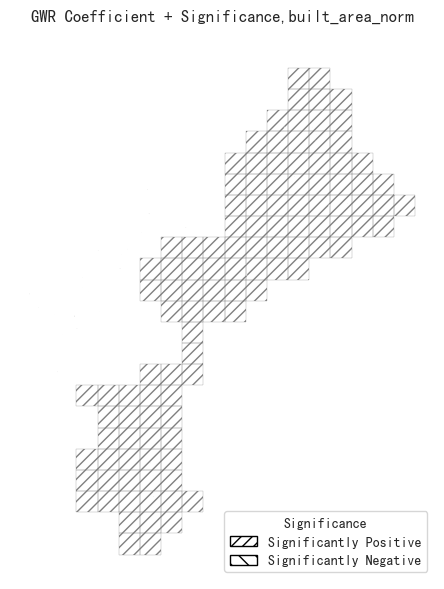

In [30]:
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
def plot_gwr_result_with_significance(gdf, coef_col, sig_col, title,processing_gdf):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))


    # 设置颜色范围对称
    col_data = gdf[coef_col]
    bound = max(abs(col_data.min()), abs(col_data.max()))
    norm = mcolors.TwoSlopeNorm(vmin=-bound, vcenter=0, vmax=bound)

    # # 画底层：系数（颜色）
    # gdf.plot(
    #     column=coef_col,
    #     cmap="coolwarm",
    #     norm=norm,
    #     ax=ax,
    #     edgecolor='grey',
    #     linewidth=0.2,
    #     legend=True,
    #     legend_kwds={
    #         'label': "GWR 回归系数",
    #         'shrink': 0.6,
    #         'orientation': 'vertical'
    #     }
    # )

    # 画上层：显著性（图案）
    for sig_val, hatch in zip([1, -1], ['///', '\\\\']):
        gdf[gdf[sig_col] == sig_val].plot(
            facecolor="none",
            edgecolor='grey',
            linewidth=0.2,
            hatch=hatch,
            ax=ax
        )
    processing_gdf.plot(ax=ax,color="black",alpha=0.5)
    # 图例（图案层）
    legend_elements = [
        Patch(facecolor='none', hatch='///', edgecolor='k', label='Significantly Positive'),
        Patch(facecolor='none', hatch='\\\\', edgecolor='k', label='Significantly Negative'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', title='Significance')

    ax.set_title(title)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

variables = [
    'farming_area_norm',
    'energy_area_norm',
    'retail_count_norm',
    'public_services_norm',
    'road_length_norm',
    'built_area_norm'
]

processing= gpd.read_file("processing_data/img/processing_red").to_crs(epsg=32632)

for var in variables:
    plot_gwr_result_with_significance(
        gdf=patches_gwr,
        coef_col=var,
        sig_col=f"sig_{var}",
        title=f"GWR Coefficient + Significance,{var}",
        processing_gdf=processing
        # key_value=
    )